In [1]:
import symforce

symforce.set_epsilon_to_symbol()
# https://github.com/symforce-org/symforce/issues/299
# https://github.com/symforce-org/symforce/issues/300
# https://colab.research.google.com/drive/11G80afyuW_Wxse4o4-Nikb8syi38Mjlk?usp=sharing#scrollTo=Xn3SeYzyRCTL

In [2]:
import numpy as np

from symforce import typing as T
from symforce.values import Values
import symforce.symbolic as sf
from symforce import logger

In [3]:
def info2mat(info):
    """This function returns a 6x6 information matrix"""
    mat = np.zeros((6, 6))
    ix = 0
    for i in range(mat.shape[0]):
        mat[i, i:] = info[ix : ix + (6 - i)]
        mat[i:, i] = info[ix : ix + (6 - i)]
        ix += 6 - i
    return mat

In [4]:
# def printData(filename_path: str):
#     with open(filename_path) as f:
#         for line in f:
#             line = line.split()
#             # print(line)
#             if line[0] == "VERTEX_SE3:QUAT":
#                 # ids.append(sf.Scalar(int(line[1])))
#                 # poses.append(sf.Pose3(R = sf.Rot3(
#                 #                 sf.Quaternion(xyz= np.array(line[5:-1], dtype=np.float64), w = float(line[-1]))),
#                 #                 t = sf.Vector3(np.array(line[2:5], dtype=np.float64))))
#                 # pass
#                 print(line)
#             elif line[0] == "EDGE_SE3:QUAT":
#                 # edges.append(sf.Vector2(np.array(line[1:3], dtype=np.int64)))
#                 # between_poses.append(sf.Pose3(R = sf.Rot3(
#                 #                 sf.Quaternion(xyz= np.array(line[6:9], dtype=np.float64), w = float(line[9]))),
#                 #                 t = sf.Vector3(np.array(line[3:6], dtype=np.float64))))
#                 # info_mats.append()
#                 print(line)


# # printData("/home/vrex/symForce/symforce_ws/pose_graph_opt/data/parking-garage.g2o")

In [5]:
prior_diagonal_sigmas = np.array(
    [
        0.05,
        0.05,
        0.05,
        0.1,
        0.1,
        0.1,
    ]
)

In [6]:
# -----------------------------------------------------------------------------
# Load the .g2o file
# -----------------------------------------------------------------------------


def build_values(filename_path: str) -> T.Tuple[Values, int]:
    # np.random.seed(42)

    # Create a problem setup and initial guess

    ids = []
    between_poses = []
    poses = []
    edges = []
    info_mats = []
    with open(filename_path) as f:
        for line in f:
            line = line.split()
            if line[0] == "VERTEX_SE3:QUAT":
                ids.append(sf.Scalar(int(line[1])))
                poses.append(
                    sf.Pose3(
                        R=sf.Rot3(
                            sf.Quaternion(
                                xyz=np.array(line[5:-1], dtype=np.float64),
                                w=float(line[-1]),
                            )
                        ),
                        t=sf.Vector3(np.array(line[2:5], dtype=np.float64)),
                    )
                )

            elif line[0] == "EDGE_SE3:QUAT":

                edges.append(sf.Vector2(np.array(line[1:3], dtype=np.int64)))
                between_poses.append(
                    sf.Pose3(
                        R=sf.Rot3(
                            sf.Quaternion(
                                xyz=np.array(line[6:9], dtype=np.float64),
                                w=float(line[9]),
                            )
                        ),
                        t=sf.Vector3(np.array(line[3:6], dtype=np.float64)),
                    )
                )
                info_mats.append(
                    sf.Matrix66(info2mat(np.array(line[10:], dtype=np.float64)))
                )

    tangent_perturbation = (
        np.random.normal(size=6) * 5 * np.array([0.005, 0.005, 0.005, 0.2, 0.2, 0.2])
    )

    # print("tangent_perturbation", tangent_perturbation)
    # print("tangent_perturbation.shape", tangent_perturbation.shape)
    # print(f"{poses[0]=}")

    # prior_pose = poses[0].retract(tangent_perturbation, epsilon=sf.numeric_epsilon)
    prior_pose = sf.Pose3(
        R=poses[0].R,
        t=sf.ops.LieGroupOps.retract(poses[0].t, tangent_perturbation[3:]),
    )
    # prior_pose = poses[0]

    # prior_pose = sf.Pose3(
    #     R=poses[0].R,
    #     t=poses[0].t,
    # ).retract(tangent_perturbation)
    # prior_pose = sf.Pose3.identity().retract(tangent_perturbation)
    # prior_pose = sf.Pose3(
    #     R=poses[0].R.retract([0.1, 2.3, -0.5]),
    #     t=poses[0].t.retract(tangent_perturbation[3:]),
    # )
    # sf.Pose3.retract(prior_pose, tangent_perturbation)

    initial_values = Values(
        ids=ids,
        between_poses=between_poses,
        posePrior=prior_pose,
        prior_diagonal_sigmas=prior_diagonal_sigmas,
        poses=poses,
        edges=edges,
        info_mats=info_mats,
        epsilon=sf.numeric_epsilon,
    )

    # max_val = -np.Inf
    # for i in range(len(edges)):
    #     # max_val = max((edges[i][1] - edges[i][0]), max_val)
    #     if (edges[i][1] - edges[i][0]) > max_val:
    #         max_val = (edges[i][1] - edges[i][0])
    #         print(max_val)
    # print(max_val)

    # values["ids"] = np.stack(ids)
    # values["between_poses"] = np.stack(between_poses)
    # values["poses"] = np.stack(poses)
    # values["edges"] = np.stack(edges)
    # values["info_mats"] = np.stack(info_mats)

    # values["epsilon"] = sf.numeric_epsilon

    # print("num ids",values["ids"])
    # print("num between_poses",values["between_poses"])
    # print("num poses",values["poses"])
    # print("num edges", values["edges"])
    # print("num info_mats",values["info_mats"])
    # print('info_mats',info_mats[0] )
    # print('info_mats',values["info_mats"][0] )
    # return values, values["poses"].shape[0]

    return initial_values

In [7]:
# Testing whether the dat loads properly or not
val = build_values(
    # "/home/vineet/symforce_ws/pose_graph_opt/data/parking-garage.g2o"
    "/home/vineet/symforce_ws/pose_graph_opt/data/sphere_bignoise_vertex3.g2o"
)

In [8]:
def pose_prior_residual(
    pose0: sf.Pose3, posePrior: sf.Pose3, diagonal_sigmas: sf.V6, epsilon: sf.Scalar
) -> sf.V6:
    tangent_error = pose0.local_coordinates(posePrior, epsilon=epsilon)
    return T.cast(
        sf.V6, sf.M.diag(diagonal_sigmas.to_flat_list()).inv() * sf.V6(tangent_error)
    )


def between_factor_residual(
    world_T_a: sf.Pose3,
    world_T_b: sf.Pose3,
    a_T_b: sf.Pose3,
    info_mats_m: sf.Matrix66,
    epsilon: sf.Scalar,
) -> sf.V6:

    # figure out covariance of world_T_a and world_T_b

    a_T_b_predicted = world_T_a.inverse() * world_T_b

    # Find the relative error between a_T_b and a_T_b_predicted in tangent space
    tangent_error = a_T_b_predicted.local_coordinates(a_T_b, epsilon=epsilon)

    # return T.cast(sf.V6, (info_mats_m).inv() * sf.V6(tangent_error))
    return T.cast(sf.V6, (info_mats_m) * sf.V6(tangent_error))

In [9]:
from symforce.opt.factor import Factor


def build_factors(values: Values):
    """
    Build factors for a problem of the given dimensionality.

    TODO: this looks wrong -> figure it out


    """
    factors = []
    factors.append(
        Factor(
            residual=pose_prior_residual,
            keys=[
                f"poses[{0}]",
                "posePrior",
                "prior_diagonal_sigmas",
                "epsilon",
            ],
        )
    )
    for i in range(len(values["edges"])):
        edge0_idx = values["edges"][i][0]
        edge1_idx = values["edges"][i][1]
        factors.append(
            Factor(
                residual=between_factor_residual,
                keys=[
                    f"poses[{edge0_idx}]",
                    f"poses[{edge1_idx}]",
                    f"between_poses[{i}]",
                    f"info_mats[{i}]",
                    "epsilon",
                ],
            )
        )
    return factors
    # # Prior factor
    # yield Factor(
    #     residual=pose_prior_residual,
    #     keys=[f"poses[{i}]", "posePrior", "epsilon"]
    # )

In [10]:
from symforce.opt.optimizer import Optimizer

_values = build_values(
    # "/home/vrex/symForce/symforce_ws/pose_graph_opt/data/parking-garage.g2o"
    # "/home/vineet/symforce_ws/pose_graph_opt/data/parking-garage.g2o"
    "/home/vineet/symforce_ws/pose_graph_opt/data/sphere_bignoise_vertex3.g2o"
)

In [11]:
# Create factors
factors = build_factors(values=_values)

In [12]:
# Select the keys to optimize - the rest will be held constant
_optimized_keys = [f"poses[{i}]" for i in range(len(_values["poses"]))]

In [13]:
# Create the optimizer
optimizer = Optimizer(
    factors=factors,
    optimized_keys=_optimized_keys,
    debug_stats=True,  # Return problem stats for every iteration
    params=Optimizer.Params(
        verbose=True, iterations=100
    ),  # Customize optimizer behavior
    # params=Optimizer.Params(verbose=True, iterations=200),
)

In [14]:
# Solve and return the result
result = optimizer.optimize(_values)

[2024-03-12 22:40:40.739] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 1388249784104784.500/0.000/4178154117660672.000, rel reduction: -2.00966
[2024-03-12 22:41:03.902] [info] LM<sym::Optimize> [iter    1] lambda: 4.000e+00, error prev/linear/new: 1388249784104784.500/0.000/4105609167241216.000, rel reduction: -1.95740
[2024-03-12 22:41:26.923] [info] LM<sym::Optimize> [iter    2] lambda: 1.600e+01, error prev/linear/new: 1388249784104784.500/0.000/3883850342072320.000, rel reduction: -1.79766
[2024-03-12 22:41:50.014] [info] LM<sym::Optimize> [iter    3] lambda: 6.400e+01, error prev/linear/new: 1388249784104784.500/0.000/3332454387548160.000, rel reduction: -1.40047
[2024-03-12 22:42:13.254] [info] LM<sym::Optimize> [iter    4] lambda: 2.560e+02, error prev/linear/new: 1388249784104784.500/0.000/2482847310938112.000, rel reduction: -0.78847
[2024-03-12 22:42:36.407] [info] LM<sym::Optimize> [iter    5] lambda: 1.024e+03, error prev/linear/new: 13882

In [15]:
# Print some values
print(f"Num iterations: {len(result.iteration_stats) - 1}")
print(f"Final error: {result.error():.6f}")

/home/vineet/symforce_ws/sym-env2/lib/python3.10/site-packages/symforce/opt/optimizer.py:203: FutureWarning: iteration_stats is deprecated, use iterations
  warnings.warn("iteration_stats is deprecated, use iterations", FutureWarning)


Num iterations: 100
Final error: 19003035648.000000


In [22]:
import matplotlib.pyplot as plt


def plot_poses(poses, ax, color="-r", label=""):
    x, y, z = [], [], []
    for n in poses:
        x.append(n.t.x)
        y.append(n.t.y)
        z.append(n.t.z)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    z = np.asarray(z, dtype=float)
    max_range = (
        np.array([x.max() - x.min(), y.max() - y.min(), z.max() - z.min()]).max() / 2.0
    )
    mid_x = (x.max() + x.min()) * 0.5
    mid_y = (y.max() + y.min()) * 0.5
    mid_z = (z.max() + z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    ax.plot(x, y, z, color)
    # ax.legend(str(label))


def plot_symforce_result(poses, ax, color="-r", label=""):
    x, y, z = [], [], []
    for n in poses:
        x.append(n.t[0])
        y.append(n.t[1])
        z.append(n.t[2])
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    z = np.asarray(z, dtype=float)
    max_range = (
        np.array([x.max() - x.min(), y.max() - y.min(), z.max() - z.min()]).max() / 2.0
    )
    mid_x = (x.max() + x.min()) * 0.5
    mid_y = (y.max() + y.min()) * 0.5
    mid_z = (z.max() + z.min()) * 0.5
    # mid_z = 0
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    # ax.set_zlim(-10, 10)
    ax.plot(x, y, z, color)
    # ax.legend(str(label))

In [23]:
initial_values = build_values(
    # "/home/vrex/symForce/symforce_ws/pose_graph_opt/data/parking-garage.g2o"
    # "/home/vineet/symforce_ws/pose_graph_opt/data/parking-garage.g2o"
    "/home/vineet/symforce_ws/pose_graph_opt/data/sphere_bignoise_vertex3.g2o"
)

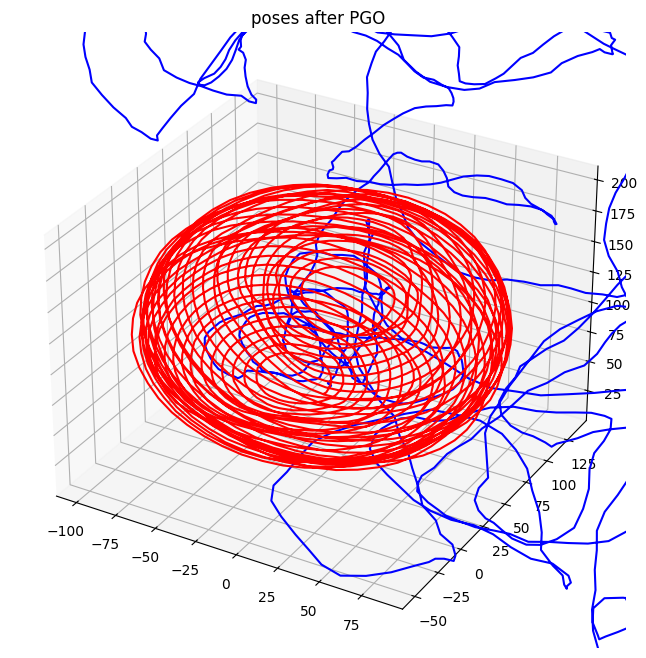

In [24]:
est_traj_fig = plt.figure(figsize=(10, 8))  # Increase the width and height as desired
ax = est_traj_fig.add_subplot(111, projection="3d")
# plt.cla()
plt.title("poses before PGO")
plot_poses(initial_values["poses"], ax, color="-b", label=str("before"))
# plot_symforce_result(result.optimized_values["poses"], ax, label="after")
plt.title("poses after PGO")
plot_symforce_result(result.optimized_values["poses"], ax, label="after")
# plt.show()
plt.show()

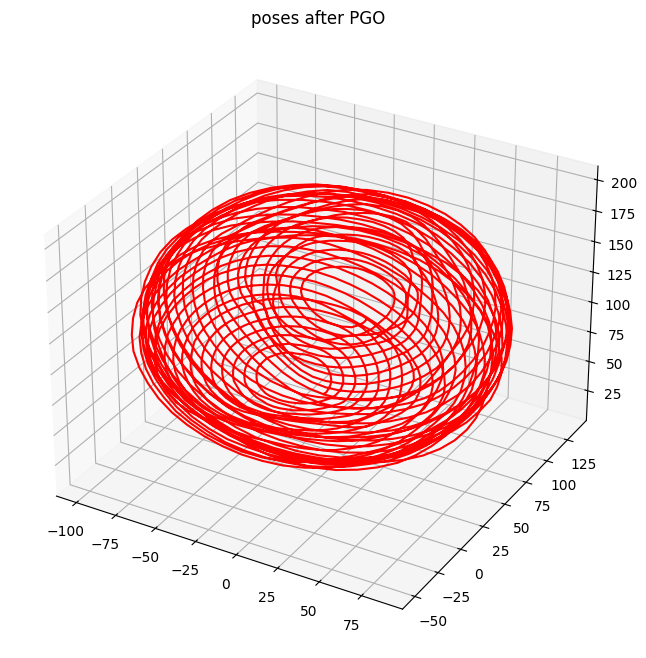

In [25]:
est_traj_fig = plt.figure(figsize=(10, 8))  # Increase the width and height as desired
ax = est_traj_fig.add_subplot(111, projection="3d")
# fig = plt.figure(figsize=(10, 8))  # Increase the width and height as desired
# ax = fig.add_subplot(111, projection="3d")
# plt.cla()
# plot_poses(initial_values["poses"], ax, color="-b", label="before")
plt.title("poses after PGO")
plot_symforce_result(result.optimized_values["poses"], ax, label="after")
plt.show()

In [26]:
def plot_correction_applied(ini_poses, final_poses, ax, color="-r", label=""):
    x_ini, y_ini, z_ini = [], [], []
    for n in ini_poses:
        x_ini.append(n.t.x)
        y_ini.append(n.t.y)
        z_ini.append(n.t.z)

    x_fin, y_fin, z_fin = [], [], []
    for n in final_poses:
        x_fin.append(n.t[0])
        y_fin.append(n.t[1])
        z_fin.append(n.t[2])
    x_ini = np.asarray(x_ini, dtype=float)
    y_ini = np.asarray(y_ini, dtype=float)
    z_ini = np.asarray(z_ini, dtype=float)

    x_fin = np.asarray(x_fin, dtype=float)
    y_fin = np.asarray(y_fin, dtype=float)
    z_fin = np.asarray(z_fin, dtype=float)

    ax[0].plot(x_ini - x_fin, marker="o", linestyle="none", color="r")
    ax[0].set_ylabel("correction")
    ax[0].set_xlabel("X-axis")

    ax[1].plot(y_ini - y_fin, marker="o", linestyle="none", color="b")
    ax[1].set_ylabel("correction")
    ax[1].set_xlabel("Y-axis")

    ax[2].plot(z_ini - z_fin, marker="o", linestyle="none", color="k")
    ax[2].set_ylabel("correction")
    ax[2].set_xlabel("Z-axis")

<Figure size 640x480 with 0 Axes>

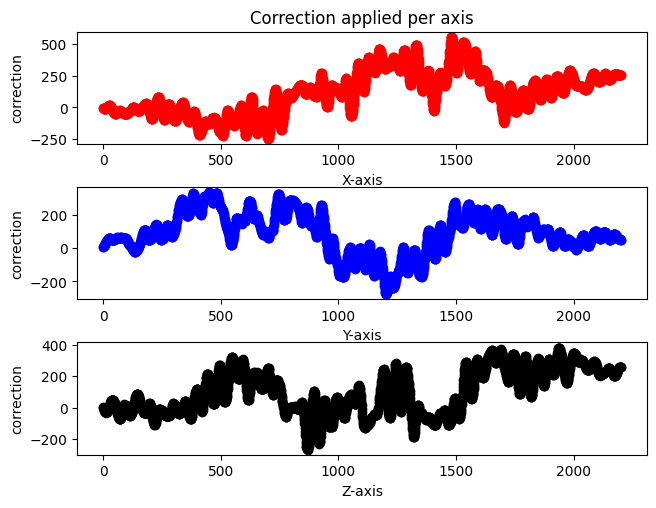

In [27]:
est_traj_fig = plt.figure()
# ax = est_traj_fig.add_subplot(111, projection="3d")
fig, axes = plt.subplots(nrows=3)
fig.tight_layout(pad=1.0)
axes[0].set_title("Correction applied per axis")

# plt.cla()
plot_correction_applied(initial_values["poses"], result.optimized_values["poses"], axes)
plt.show()